# Import All of the Necessary Libraries

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\amukh\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

# Load the Original Files

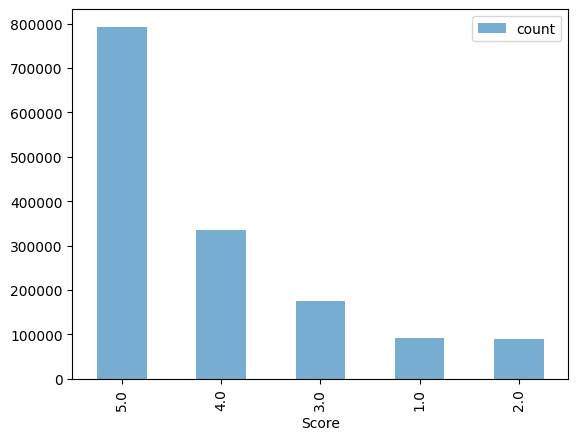

DATA IS LOADED


In [31]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

train_set['Score'].value_counts().plot(kind='bar', legend=True, alpha=.6)
plt.show()

print("DATA IS LOADED")

# Add Features and Save to New File

Note: this also includes exists(), which allows the files to simply be loaded if this section of the code has already been ran.

In [ ]:
def add_features_to(df):
    # Fill text fields and combine text + summary 
    df['Text'] = df['Text'].fillna('')
    df['Summary'] = df['Summary'].fillna('')
    df['All_Text'] = df['Text'] + ' ' + df['Summary']

    # Simple text-based features
    df['Review_Length'] = df.apply(lambda row : len(row['Text'].split()) if type(row['Text']) == str else 0, axis = 1)
    df['Exclamations'] = df['All_Text'].str.count('!')
    df['Questions'] = df['All_Text'].str.count(r'\?')

    # Harder test-based features
    negation_words = set(opinion_lexicon.negative())
    df['Negation_Count'] = df['All_Text'].apply(lambda x: sum(1 for word in x.split() if word.lower() in negation_words))
    positive_words = set(opinion_lexicon.positive())
    df['Positive_Count'] = df['All_Text'].apply(lambda text: sum(1 for word in text.split() if word.lower() in positive_words))
    df['Sentiment'] = df['All_Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # Product and user counts
    df['Prod_Count'] = df.groupby('ProductId')['ProductId'].transform('count')
    df['User_Count'] = df.groupby('UserId')['UserId'].transform('count')

    # Format
    df.replace([float('inf'), -float('inf')], 0, inplace=True)

    # TF-IDF
    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['All_Text'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])])
    tfidf_df.index = df.index

    df = pd.concat([df, tfidf_df], axis=1)

    return df

# Load files if they already exist
if exists('X_train.csv'):
    X_train = pd.read_csv("X_train.csv")
if exists('X_submission.csv'):
    X_submission = pd.read_csv("X_submission.csv")

else:
    # Apply the function that adds features
    train = add_features_to(train_set)

    # Merge
    X_submission = pd.merge(train, test_set, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    
    # Remove null scores from the training set
    X_train =  train[train['Score'].notnull()]
    
    # create the files for the first time
    X_submission.to_csv("X_submission.csv", index=False)
    X_train.to_csv("X_train.csv", index=False)
 

# Test-Train Split (including optional sampling)

In [ ]:
# Sample
X_train_sampled = X_train

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_sampled.drop(columns=['Score']),
    X_train_sampled['Score'],
    test_size=1/4.0,
    random_state=0
)


# Removing Unnecessary Features

In [64]:
# Find unwanted features
exclude = ['Id', 'ProductId', 'UserId', 'Summary', 'Text', 'All_Text', 'Score']
features = [col for col in X_train.columns if col not in exclude]

# Exclude unwanted features
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]


# Creating a Logistic Regression Model with TruncatedSVD

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale the data
    ('svd', TruncatedSVD(n_components=350, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(random_state=42, max_iter=100000))  # Classification model
])

pipeline.fit(X_train_select, Y_train)
Y_test_predictions = pipeline.predict(X_test_select)


# Model Evaluation

Accuracy =  0.6396121033242131


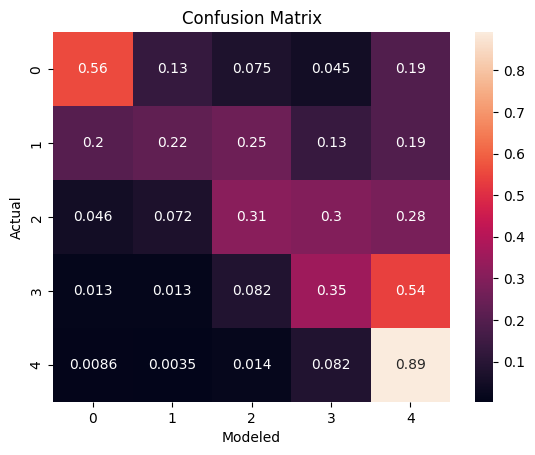

In [70]:
# Calculate accuracy
print("Accuracy = ", accuracy_score(Y_test, Y_test_predictions))

# Plot confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Modeled')
plt.show()

# Create submission file

In [71]:
# Create submission file
X_submission['Score'] = pipeline.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("submission.csv", index=False)